# Healthcare - Persistency of a Drug

## <u> Model Selection and Model Building: </u>

Import libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier




Read cleaned data

In [31]:
df = pd.read_csv("New_data.csv")
# First column in df
# is just serial number, we can drop that column
df.drop(columns=df.columns[0], 
        axis=1, 
        inplace=True)
df.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,min_max_Dexa_Freq_During_Rx,min_max_Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,0,0.0,0.00
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,0,0.0,0.00
2,Non-Persistent,Female,Caucasian,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,2,0.0,0.50
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,1,0.0,0.25
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,...,N,N,N,N,N,N,N,1,0.0,0.25


In [32]:
# Dividing features into categorical and numerical for pipeline step

categorical = [col for col in df.columns if df[col].dtypes=='O']
categorical.remove("Persistency_Flag")
numerical = [col for col in df.columns if df[col].dtypes!='O']

## 1. Logistic Regression

In [34]:
to_scale = numerical
for col in to_scale:
    df[col].replace(",",".",regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
to_enc = categorical
for col in to_enc:
    df[col] = df[col].astype("category")

numeric_features = to_scale

# pipeline transform steps for numerical features
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features = to_enc

# Encoding categorical features
categorical_transformer = OneHotEncoder()

# Preprocessor using ColumnTransformer
preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

# Split data
y = df["Persistency_Flag"]
X = df.drop(columns={"Persistency_Flag"})

# Model
lr = LogisticRegression()

# Build pipeline
pipeline_steps = [('pre', preprocessor), ("forest", lr) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

c:\Users\soniy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8165760869565217

In [35]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

Non-Persistent       0.82      0.93      0.87       501
    Persistent       0.80      0.57      0.67       235

      accuracy                           0.82       736
     macro avg       0.81      0.75      0.77       736
  weighted avg       0.81      0.82      0.81       736



Text(0.5, 257.44, 'Predicted label')

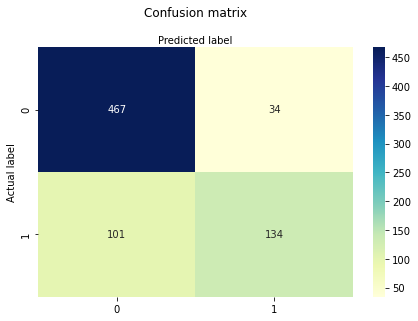

In [36]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

fig, ax = plt.subplots() 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

## 2. Decision Tree Classifier

In [39]:
to_scale = numerical
for col in to_scale:
    df[col].replace(",",".",regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
to_enc = categorical
for col in to_enc:
    df[col] = df[col].astype("category")

numeric_features = to_scale

# pipeline transform steps for numerical features
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features = to_enc

# Encoding categorical features
categorical_transformer = OneHotEncoder()

# Preprocessor using ColumnTransformer
preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

# Split data
y = df["Persistency_Flag"]
X = df.drop(columns={"Persistency_Flag"})

# Model
dtc = DecisionTreeClassifier()

# Build pipeline
pipeline_steps = [('pre', preprocessor), ("forest", dtc) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7323369565217391

In [40]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Persistent       0.81      0.79      0.80       504
    Persistent       0.57      0.60      0.59       232

      accuracy                           0.73       736
     macro avg       0.69      0.70      0.69       736
  weighted avg       0.74      0.73      0.73       736



Text(0.5, 257.44, 'Predicted label')

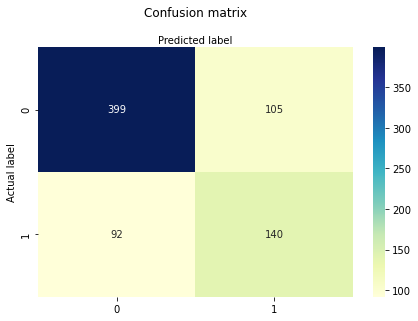

In [41]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

fig, ax = plt.subplots() 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

## 3. Random Forest Classifier

In [43]:
to_scale = numerical
for col in to_scale:
    df[col].replace(",",".",regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
to_enc = categorical
for col in to_enc:
    df[col] = df[col].astype("category")

numeric_features = to_scale

# pipeline transform steps for numerical features
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features = to_enc

# Encoding categorical features
categorical_transformer = OneHotEncoder()

# Preprocessor using ColumnTransformer
preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

# Split data
y = df["Persistency_Flag"]
X = df.drop(columns={"Persistency_Flag"})

# Model
rfc = RandomForestClassifier(n_jobs=-1)

# Build pipeline
pipeline_steps = [('pre', preprocessor), ("forest", rfc) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8097826086956522

In [44]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Persistent       0.84      0.91      0.87       518
    Persistent       0.73      0.57      0.64       218

      accuracy                           0.81       736
     macro avg       0.78      0.74      0.76       736
  weighted avg       0.80      0.81      0.80       736



Text(0.5, 257.44, 'Predicted label')

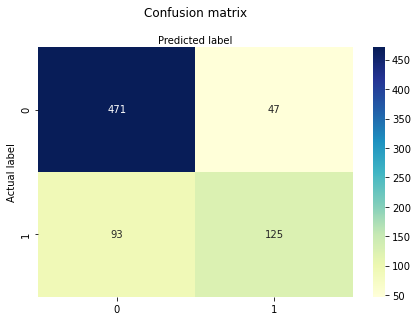

In [45]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

fig, ax = plt.subplots() 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

## 4. KNN

In [46]:
to_scale = numerical
for col in to_scale:
    df[col].replace(",",".",regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
to_enc = categorical
for col in to_enc:
    df[col] = df[col].astype("category")

numeric_features = to_scale

# pipeline transform steps for numerical features
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features = to_enc

# Encoding categorical features
categorical_transformer = OneHotEncoder()

# Preprocessor using ColumnTransformer
preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

# Split data
y = df["Persistency_Flag"]
X = df.drop(columns={"Persistency_Flag"})

# Model
knn = KNeighborsClassifier()

# Build pipeline
pipeline_steps = [('pre', preprocessor), ("forest", knn) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8002717391304348

In [47]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Persistent       0.80      0.95      0.87       522
    Persistent       0.78      0.43      0.56       214

      accuracy                           0.80       736
     macro avg       0.79      0.69      0.71       736
  weighted avg       0.80      0.80      0.78       736



In [48]:
train_pred = pipe.predict(X_train)

Text(0.5, 257.44, 'Predicted label')

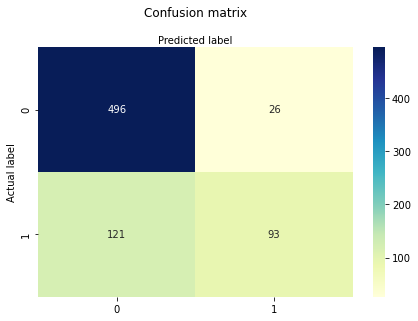

In [49]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

fig, ax = plt.subplots() 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

# <u>Best Model </u>

Random Forest Classifier is the best model based on accuracy score.